<ipython-input-16-228a441f9b68>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])
<ipython-input-16-228a441f9b68>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='ffill')


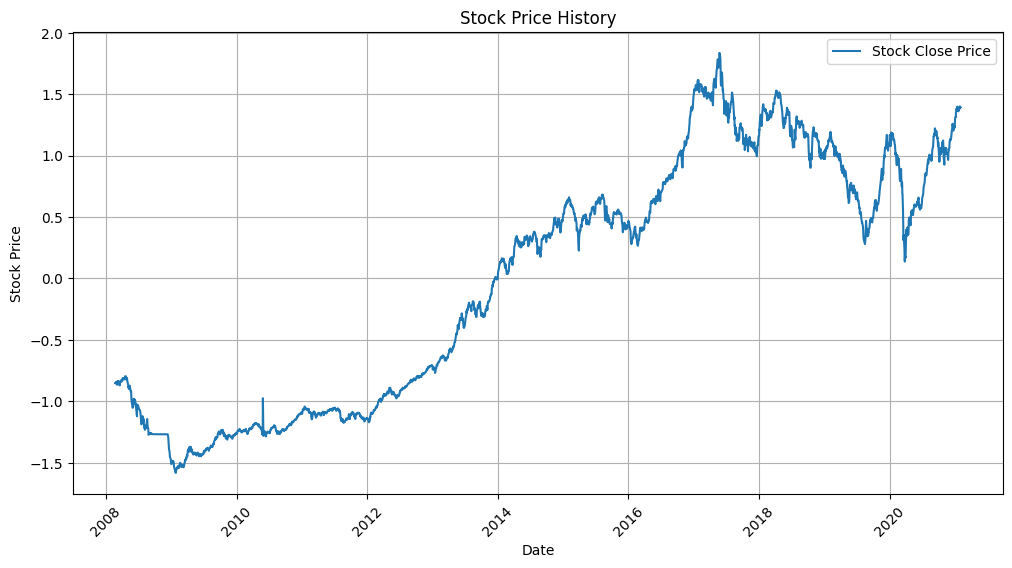

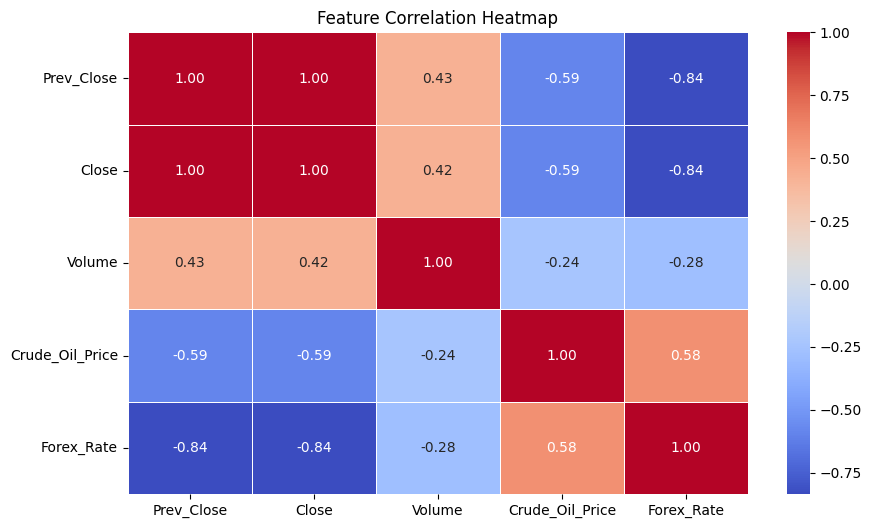

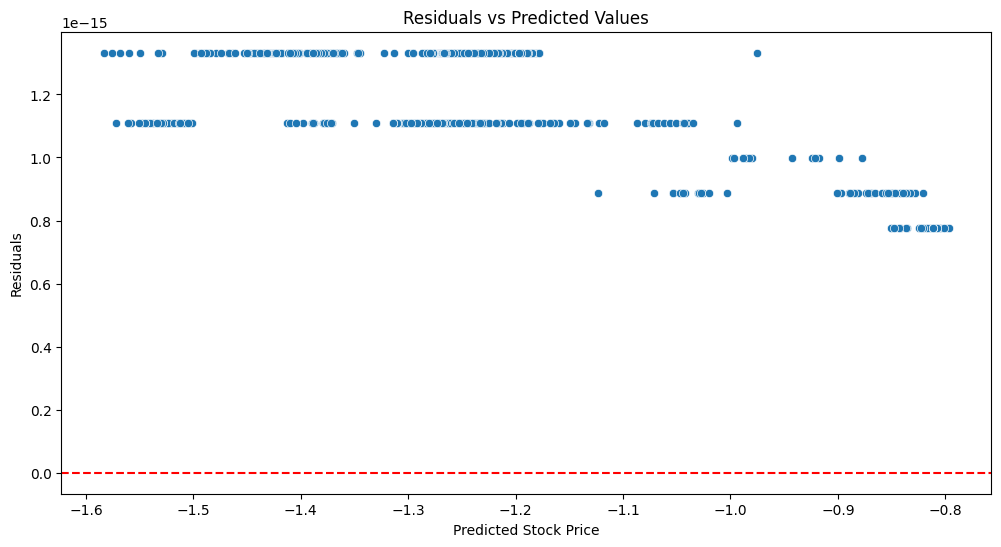

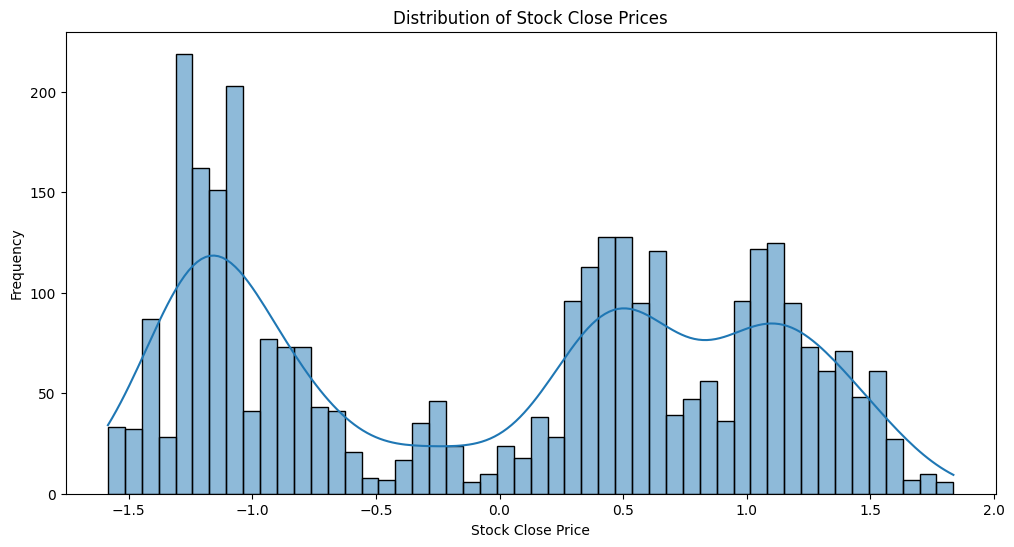

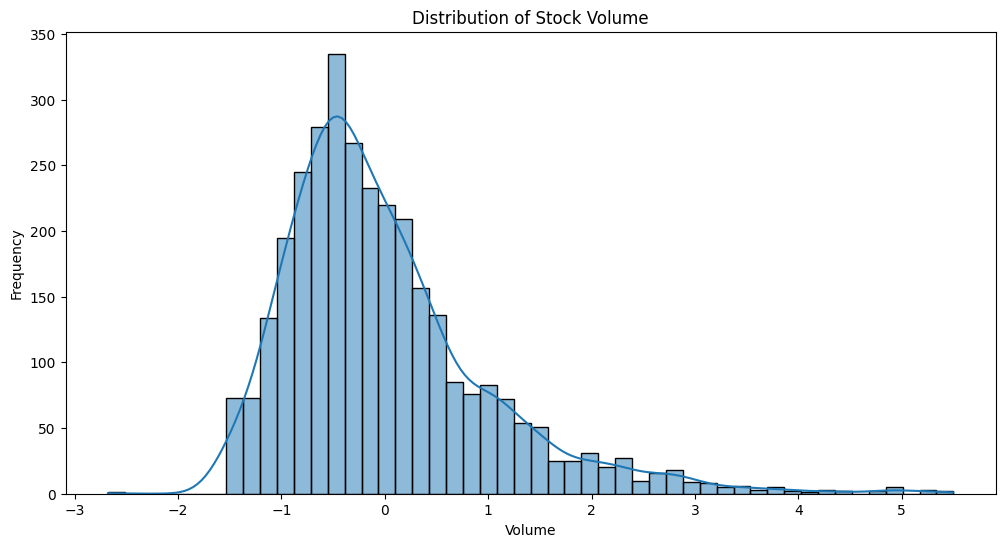

Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
R² (Model Accuracy): 1.00
Pearson Correlation: 1.00

Feature Importance (Coefficients):
                  Coefficient
Prev_Close       9.034318e-16
Close            1.000000e+00
Volume           5.551115e-17
Crude_Oil_Price  0.000000e+00
Forex_Rate      -1.110223e-16


FloatText(value=0.0, description='Prev Close:')

FloatText(value=0.0, description='Today Close:')

IntText(value=0, description='Volume:')

FloatText(value=0.0, description='Crude Oil Price:')

FloatText(value=0.0, description='Forex Rate:')

Button(description='Predict', style=ButtonStyle())

Output()

In [16]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from IPython.display import display
import numpy as np

# Load stock data
stock_data = pd.read_csv('/stock-exchange-kse-100pakistan (2).csv')

# Load crude oil price and forex rate data
crude_oil_data = pd.read_csv('/crude-oil-price.csv')
forex_data = pd.read_csv('/Foreign_Exchange_Rates.csv')

# Convert 'Date' columns to datetime for proper merging
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
crude_oil_data['Date'] = pd.to_datetime(crude_oil_data['date']).dt.tz_localize(None)
forex_data['Date'] = pd.to_datetime(forex_data['Time Serie']).dt.tz_localize(None)

# Clean the stock data columns to remove commas and convert to numeric
stock_data['Close'] = stock_data['Close'].replace({',': ''}, regex=True).astype(float)
stock_data['Volume'] = stock_data['Volume'].replace({',': ''}, regex=True).astype(int)
crude_oil_data['price'] = crude_oil_data['price'].replace({',': ''}, regex=True).astype(float)

# Merge datasets on the 'Date' column
merged_data = pd.merge(stock_data, crude_oil_data[['Date', 'price']], on='Date', how='left')
merged_data = pd.merge(merged_data, forex_data[['Date', 'AUSTRALIA - AUSTRALIAN DOLLAR/US$']], on='Date', how='left')

# Rename columns for clarity
merged_data = merged_data.rename(columns={'price': 'Crude_Oil_Price', 'AUSTRALIA - AUSTRALIAN DOLLAR/US$': 'Forex_Rate'})

# Handle missing values and normalize the data
merged_data.replace('ND', pd.NA, inplace=True)
merged_data['Crude_Oil_Price'] = pd.to_numeric(merged_data['Crude_Oil_Price'], errors='coerce')
merged_data['Forex_Rate'] = pd.to_numeric(merged_data['Forex_Rate'], errors='coerce')
merged_data = merged_data.fillna(method='ffill')

# Feature engineering: create a 'Prev_Close' feature
merged_data['Prev_Close'] = merged_data['Close'].shift(1)
merged_data = merged_data.dropna()

# Normalize the numerical features
numeric_features = merged_data.select_dtypes(include=['number']).columns
merged_data[numeric_features] = (merged_data[numeric_features] - merged_data[numeric_features].mean()) / merged_data[numeric_features].std()

# Select relevant features and target variable
features = ['Prev_Close', 'Close', 'Volume', 'Crude_Oil_Price', 'Forex_Rate']
X = merged_data[features]
y = merged_data['Close']

# Split the data into training and testing sets
split = int(0.8 * len(merged_data))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manually compute RMSE

# Calculate the correlation between actual and predicted values
correlation, _ = pearsonr(y_test, y_pred)

# Visualization: Plot historical stock prices
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Close'], label='Stock Close Price')
plt.title('Stock Price History')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Visualization: Correlation Heatmap
correlation_matrix = merged_data[['Prev_Close', 'Close', 'Volume', 'Crude_Oil_Price', 'Forex_Rate']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Visualization: Residuals Plot
plt.figure(figsize=(12, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Stock Price')
plt.ylabel('Residuals')
plt.show()

# Visualization: Histogram of Stock Prices
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['Close'], kde=True, bins=50)
plt.title('Distribution of Stock Close Prices')
plt.xlabel('Stock Close Price')
plt.ylabel('Frequency')
plt.show()

# Visualization: Histogram of Volume
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['Volume'], kde=True, bins=50)
plt.title('Distribution of Stock Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# Insight Generation: Key Model Metrics
insights = {
    'Mean Squared Error (MSE)': mse,
    'Mean Absolute Error (MAE)': mae,
    'Root Mean Squared Error (RMSE)': rmse,
    'R² (Model Accuracy)': r2,
    'Pearson Correlation': correlation
}

# Display Insights
for key, value in insights.items():
    print(f"{key}: {value:.2f}")

# Insight on Feature Importance (Optional)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nFeature Importance (Coefficients):")
print(coefficients)

# Define the widgets for user input
prev_close_widget = widgets.FloatText(description="Prev Close:")
close_widget = widgets.FloatText(description="Today Close:")
volume_widget = widgets.IntText(description="Volume:")
crude_oil_widget = widgets.FloatText(description="Crude Oil Price:")
forex_widget = widgets.FloatText(description="Forex Rate:")

output = widgets.Output()

# Function to make prediction
def on_button_click(b):
    prev_close = prev_close_widget.value
    close = close_widget.value
    volume = volume_widget.value
    crude_oil_price = crude_oil_widget.value
    forex_rate = forex_widget.value

    new_data = pd.DataFrame({
        'Prev_Close': [prev_close],
        'Close': [close],
        'Volume': [volume],
        'Crude_Oil_Price': [crude_oil_price],
        'Forex_Rate': [forex_rate]
    })

    new_data[numeric_features] = (new_data[numeric_features] - merged_data[numeric_features].mean()) / merged_data[numeric_features].std()

    predicted_stock_price = model.predict(new_data)

    with output:
        print(f"Predicted Stock Price: {predicted_stock_price[0]:.2f}")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"Model Accuracy (R²): {r2:.2f}")
        print(f"Pearson Correlation: {correlation:.2f}")

# Button to trigger prediction
predict_button = widgets.Button(description="Predict")
predict_button.on_click(on_button_click)

# Display widgets
display(prev_close_widget, close_widget, volume_widget, crude_oil_widget, forex_widget, predict_button, output)
